# Importing libraries

In [ ]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image

### Loading and pre-processing the data

In [11]:
train_image = []
train_annotation = []

import glob
image_file = glob.glob("/drone_dataset_yolo/dataset_txt/*.jpg")

for i in image_file:     #slicing for insufficient memory
    Load_image = Image.open(i).convert('RGB')
    nmpy_img = Load_image.resize((258,258))
    train_image.append(np.asarray(nmpy_img))
    
    seperate_path = i.split('.')
    seperate_path[1] = '.txt'
    
    with open(seperate_path[0]+seperate_path[1]) as f:
        lines = f.readlines()
        tmp_lst = lines[0].split(' ')
        #label = int(tmp_lst[0])
        startX = float(tmp_lst[1])
        startY = float(tmp_lst[2])
        endX = float(tmp_lst[3])
        endY = float(tmp_lst[4])
        train_annotation.append((startX, startY, endX, endY))

### Displaying sample images

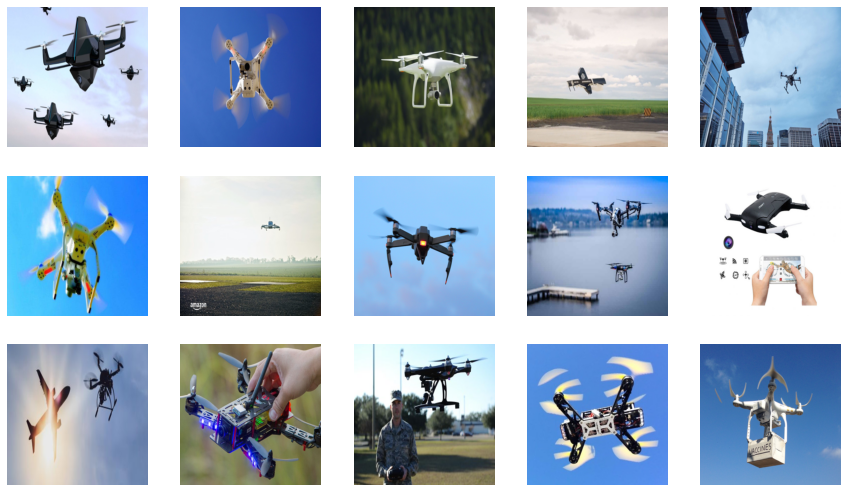

In [ ]:
len(train_image)

plt.figure(figsize=(15, 15))

for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

### Splitting the data into training and testing sets

In [12]:
from sklearn.model_selection import train_test_split
data = np.array(train_image, dtype='float32') / 255.0   # memory not sufficient !!
targets = np.array(train_annotation, dtype='float32')

split = train_test_split(data, targets, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

# Printing the shapes of the data and targets arrays

data.shape, targets.shape

((1359, 258, 258, 3), (1359, 4))

## CNN

### VGG16

### Building model

In [ ]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

def build_vggmodel():
    vgg = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(258, 258, 3)))

    vgg.trainable = True

    flatten = vgg.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="linear")(bboxHead)

    vggmodel = Model(inputs=vgg.input, outputs=bboxHead)
    
    return vggmodel

vggmodel = build_vggmodel()

vggmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 258, 258, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 258, 258, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 258, 258, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 129, 129, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 129, 129, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 129, 129, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

## Compiling and training the model

In [ ]:
vggmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

save_best = tf.keras.callbacks.ModelCheckpoint("VGGModel.h5",monitor='val_loss',save_best_only=True, verbose=1)

historyvgg= vggmodel.fit(trainImages, trainTargets, validation_split=0.2, batch_size= 16, epochs=10, verbose=1)

Epoch 1/10
62/62 [==============================] - 580s 9s/step - loss: 0.3771 - accuracy: 0.5184 - val_loss: 0.0366 - val_accuracy: 0.6082
Epoch 2/10
62/62 [==============================] - 582s 9s/step - loss: 0.0350 - accuracy: 0.6258 - val_loss: 0.0355 - val_accuracy: 0.6245
Epoch 3/10
62/62 [==============================] - 582s 9s/step - loss: 0.0297 - accuracy: 0.6452 - val_loss: 0.0252 - val_accuracy: 0.6367
Epoch 4/10
62/62 [==============================] - 579s 9s/step - loss: 0.0314 - accuracy: 0.6288 - val_loss: 0.0271 - val_accuracy: 0.5918
Epoch 5/10
62/62 [==============================] - 579s 9s/step - loss: 0.0258 - accuracy: 0.6820 - val_loss: 0.0298 - val_accuracy: 0.4776
Epoch 6/10
62/62 [==============================] - 584s 9s/step - loss: 0.0232 - accuracy: 0.6892 - val_loss: 0.0243 - val_accuracy: 0.6653
Epoch 7/10
62/62 [==============================] - 585s 9s/step - loss: 0.0255 - accuracy: 0.6810 - val_loss: 0.0270 - val_accuracy: 0.6082
Epoch 8/10
62

### Predictions on train images

In [ ]:
vggmodel = tf.keras.models.load_model('./Model.h5')

vggmodel.predict(trainImages[:10], verbose=1)

1/1 [==============================] - 2s 2s/step


array([[0.5825373 , 0.46074587, 0.6322933 , 0.41392812],
       [0.6133289 , 0.3843116 , 0.64267844, 0.44300243],
       [0.5707962 , 0.4805889 , 0.49623105, 0.45567256],
       [0.4951327 , 0.41042727, 0.5579673 , 0.5138606 ],
       [0.5374147 , 0.45503056, 0.7185692 , 0.4715309 ],
       [0.6180817 , 0.4483091 , 0.8344827 , 0.5387133 ],
       [0.53392655, 0.4567277 , 0.57502705, 0.4386972 ],
       [0.5731315 , 0.46417502, 0.7995015 , 0.54045737],
       [0.57134354, 0.41270518, 0.49315795, 0.31333533],
       [0.580101  , 0.4926869 , 0.88180196, 0.6510051 ]], dtype=float32)

### Performance

#### Acccuracy vs No. of epochs graph

Final Training Accuracy: 0.7300613522529602
Final Validation Accuracy: 0.6693877577781677


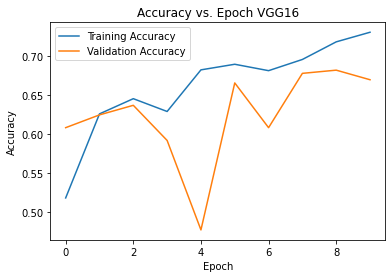

In [ ]:
print('Final Training Accuracy:', historyvgg.history['accuracy'][-1])
print('Final Validation Accuracy:', historyvgg.history['val_accuracy'][-1])

plt.plot(historyvgg.history['accuracy'], label='Training Accuracy')
plt.plot(historyvgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch VGG16')
plt.legend()
plt.show()

#### Loss vs No. of epochs graph

Final Training Loss: 0.020221635699272156
Final Validation Loss: 0.020556705072522163


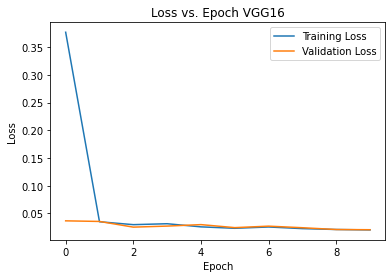

In [ ]:
print('Final Training Loss:', historyvgg.history['loss'][-1])
print('Final Validation Loss:', historyvgg.history['val_loss'][-1])

plt.plot(historyvgg.history['loss'], label='Training Loss')
plt.plot(historyvgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch VGG16')
plt.legend()
plt.show()

### Evaluating on test images

In [ ]:
loss, accuracy = vggmodel.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 16s 3s/step - loss: 0.0340 - accuracy: 0.6324
Test Loss: 0.03395042195916176
Test Accuracy: 0.6323529481887817


#### Error

5/5 [==============================] - 16s 3s/step
Mean Squared Error: 0.033950426
Mean Absolute Error: 0.13260102
R^2 Score: -0.031637886272377846


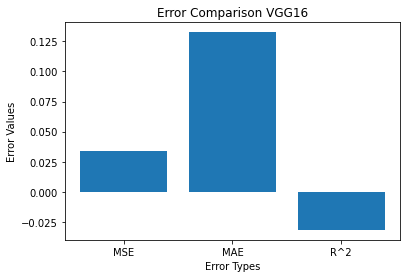

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# predict the test images using the trained model
predictions = vggmodel.predict(testImages)

# calculate the mean squared error
mse = mean_squared_error(testTargets, predictions)
print("Mean Squared Error:", mse)

# calculate and print the mean absolute error
mae = mean_absolute_error(testTargets, predictions)
print("Mean Absolute Error:", mae)

# calculate and print the R^2 score
r2 = r2_score(testTargets, predictions)
print("R^2 Score:", r2)

# plot errors
plt.bar(['MSE', 'MAE', 'R^2'], [mse, mae, r2])
plt.title('Error Comparison VGG16')
plt.xlabel('Error Types')
plt.ylabel('Error Values')
plt.show()


## Resnet50

### Building model

In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model, Input

def build_resnetmodel():
    resnet = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(258, 258, 3)))

    resnet.trainable = True

    flatten = resnet.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="linear")(bboxHead)

    resnetmodel = Model(inputs=resnet.input, outputs=bboxHead)
    
    return resnetmodel

resnetmodel = build_resnetmodel()

resnetmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 258, 258, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 264, 264, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 129, 129, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Compiling and training the model

In [ ]:
resnetmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

save_best = tf.keras.callbacks.ModelCheckpoint("RESNETModel.h5", verbose=1)

historyresnet= resnetmodel.fit(trainImages, trainTargets, validation_split=0.2, batch_size= 16, epochs=5, verbose=1)

Epoch 1/5
62/62 [==============================] - 429s 7s/step - loss: 19.3366 - accuracy: 0.3814 - val_loss: 85.4376 - val_accuracy: 0.1224
Epoch 2/5
62/62 [==============================] - 402s 6s/step - loss: 0.0368 - accuracy: 0.6166 - val_loss: 0.6212 - val_accuracy: 0.1143
Epoch 3/5
62/62 [==============================] - 406s 7s/step - loss: 0.0292 - accuracy: 0.6380 - val_loss: 0.2060 - val_accuracy: 0.1224
Epoch 4/5
62/62 [==============================] - 434s 7s/step - loss: 0.0232 - accuracy: 0.6912 - val_loss: 0.1863 - val_accuracy: 0.1469
Epoch 5/5
62/62 [==============================] - 409s 7s/step - loss: 0.0174 - accuracy: 0.7352 - val_loss: 0.1596 - val_accuracy: 0.1551


### Predictions on train images

In [ ]:
resnetmodel = tf.keras.models.load_model('./RESNETModel.h5')

resnetmodel.predict(trainImages[:10], verbose=1)

1/1 [==============================] - 2s 2s/step


array([[0.20311397, 0.06255092, 0.26223865, 0.35721734],
       [0.1876066 , 0.05498945, 0.22687595, 0.30801684],
       [0.19413784, 0.05945655, 0.246785  , 0.33816755],
       [0.19960558, 0.062148  , 0.25265536, 0.34065318],
       [0.15705007, 0.04908301, 0.1840157 , 0.25842875],
       [0.18854392, 0.06186888, 0.2383138 , 0.32267264],
       [0.16217604, 0.05146961, 0.19360648, 0.27013898],
       [0.19362673, 0.05726403, 0.24475856, 0.33739993],
       [0.19359428, 0.05829326, 0.24164332, 0.32896402],
       [0.2022379 , 0.06106587, 0.25864285, 0.3523651 ]], dtype=float32)

### Performance

#### Acccuracy vs No. of epochs graph

Final Training Accuracy: 0.6809815764427185
Final Validation Accuracy: 0.6448979377746582


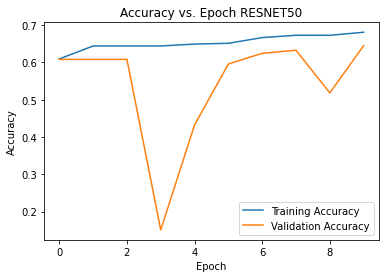

In [ ]:
print('Final Training Accuracy:', historyresnet.history['accuracy'][-1])
print('Final Validation Accuracy:', historyresnet.history['val_accuracy'][-1])

plt.plot(historyresnet.history['accuracy'], label='Training Accuracy')
plt.plot(historyresnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch RESNET50')
plt.legend()
plt.show()

#### Loss vs No. of epochs graph

Final Training Loss: 0.020651470869779587
Final Validation Loss: 0.024922046810388565


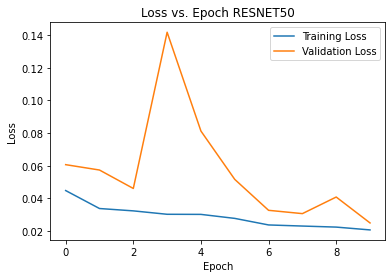

In [ ]:
print('Final Training Loss:', historyresnet.history['loss'][-1])
print('Final Validation Loss:', historyresnet.history['val_loss'][-1])

plt.plot(historyresnet.history['loss'], label='Training Loss')
plt.plot(historyresnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch RESNET50')
plt.legend()
plt.show()

### Evaluating on test images

In [ ]:
loss, accuracy = resnetmodel.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 11s 2s/step - loss: 0.1638 - accuracy: 0.1176
Test Loss: 0.16376009583473206
Test Accuracy: 0.11764705926179886


#### Error

5/5 [==============================] - 11s 2s/step
Mean Squared Error: 0.1694056
Mean Absolute Error: 0.32162493
R^2 Score: -2.766883867313558


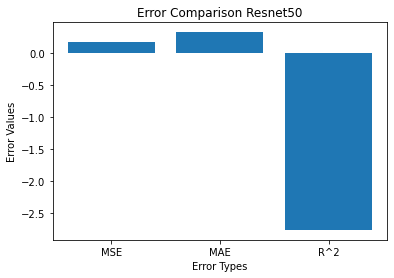

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# predict the test images using the trained model
predictions = resnetmodel.predict(testImages)

# calculate the mean squared error
mse = mean_squared_error(testTargets, predictions)
print("Mean Squared Error:", mse)

# calculate and print the mean absolute error
mae = mean_absolute_error(testTargets, predictions)
print("Mean Absolute Error:", mae)

# calculate and print the R^2 score
r2 = r2_score(testTargets, predictions)
print("R^2 Score:", r2)

# plot errors
plt.bar(['MSE', 'MAE', 'R^2'], [mse, mae, r2])
plt.title('Error Comparison Resnet50')
plt.xlabel('Error Types')
plt.ylabel('Error Values')
plt.show()


## YOLOv8

In [ ]:
pip install ultralytics

In [13]:
from ultralytics import YOLO

In [14]:
# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

In [15]:
# Use the model
model.train(data="coco128.yaml", epochs=3)  # train the model

Ultralytics YOLOv8.0.74 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspace=4,

In [17]:
metrics = model.val()  # evaluate model performance on the validation set
results = model("drone_dataset_yolo/dataset_txt/0014.jpg")  # predict on an image
success = model.export(format="onnx")  # export the model to ONNX format

Ultralytics YOLOv8.0.74 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:38<00:00,  4.83s/it]
                   all        128        929      0.677      0.585      0.646      0.476
                person        128        254       0.74      0.682      0.777      0.558
               bicycle        128          6          1      0.323      0.375      0.282
                   car        128         46      0.825      0.217      0.313      0.192
            motorcycle        128          5      0.654        0.8       0.92      0.737
              airplane        128          6      0.727      0.894      0.927       0.72
                   bus        128          7      0.839      0.714      0.722      0.641
                 train        128

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

